<a href="https://colab.research.google.com/github/pgpanagiotidis/Temporal-Fusion-Transformers-for-stock-price-forecasting/blob/main/Pfizer_stock_closing_price_forecasting_enhanced_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths
import copy
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.examples import get_stallion_data
import csv
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [5]:
#read the data
df_Pfizer = pd.read_csv('Pfizer.csv')
df_AstraZeneca= pd.read_csv('AstraZeneca.csv')

In [6]:
#rename the column Close to Close_AstraZeneca
df_AstraZeneca=df_AstraZeneca.rename(columns={"Close": "Close_AstraZeneca"})

In [7]:
#append the the closing prices of the AstraZeneca stock to the df_Pfizer dataframe
closing_prices = df_AstraZeneca["Close_AstraZeneca"]
df_Pfizer['Close_AstraZeneca']=closing_prices 

In [8]:
#convert column to datetime
df_Pfizer["Date"]= pd.to_datetime(df_Pfizer["Date"])

In [9]:
#add time index
time_idx=np.arange(1520)
df_Pfizer["time_idx"] = time_idx


In [10]:
#create the group column
df_Pfizer['group']=[0 for i in range(0,1520)]

In [11]:
# keep only the necessary columns
df_Pfizer.drop(['Open', 'High', 'Low','Adj Close', 'Volume'], axis=1, inplace=True)

In [13]:
#split the dataset into train, validation and test set
max_prediction_length = 3
max_encoder_length = 14

training_cutoff = int(df_Pfizer["time_idx"].max()*0.6)
print("training_cutoff",training_cutoff)

training = TimeSeriesDataSet(
        df_Pfizer[lambda x: x.time_idx <= training_cutoff],
        group_ids=["group"],
        target='Close',
        time_idx="time_idx",
        min_encoder_length=max_encoder_length,  # keep encoder length long (as it is in the validation set)
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        time_varying_unknown_reals=['Close','Close_AstraZeneca'],
        time_varying_known_reals=["time_idx"],
        target_normalizer=GroupNormalizer(
            groups=["group"], transformation="softplus"
        ),  # use softplus and normalize by group, SoftPlus is a smooth approximation to the ReLU function and can be used to constrain the output of a machine to always be positive.
        add_relative_time_idx=True,
        add_target_scales=True,
        # add_encoder_length=True,
    )

validation_cutoff = training_cutoff +int(df_Pfizer["time_idx"].max()*0.2)# "YYYY-MM-DD"  # day for cutoff
print("validation_cutoff",validation_cutoff)
    

# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(training, df_Pfizer[lambda x: (x.time_idx > training_cutoff) & (x.time_idx <= validation_cutoff)], stop_randomization=True)   
    
# create test dataset using the same normalization techniques as for the training dataset
test = TimeSeriesDataSet.from_dataset(training, df_Pfizer[lambda x: x.time_idx > validation_cutoff], stop_randomization=True)
print(test)
BATCH_SIZE = 128 
# convert datasets to dataloaders for training
train_dataloader = training.to_dataloader(train=True, batch_size=BATCH_SIZE, shuffle = False)
val_dataloader = validation.to_dataloader(train=False, batch_size=BATCH_SIZE, shuffle = False)
test_dataloader = test.to_dataloader(train=False, batch_size=BATCH_SIZE, shuffle = False)
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df_Pfizer, predict=False, stop_randomization=True)


x, y = next(iter(val_dataloader))
print("x =", x)
print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

training_cutoff 911
validation_cutoff 1214
x = {'encoder_cat': tensor([], size=(128, 14, 0), dtype=torch.int64), 'encoder_cont': tensor([[[-7.1054e-15,  8.8818e-16,  1.7340e+00, -1.0000e+00,  2.8684e+00,
           1.9464e+00],
         [-7.1054e-15,  8.8818e-16,  1.7377e+00, -9.2857e-01,  2.6392e+00,
           1.9190e+00],
         [-7.1054e-15,  8.8818e-16,  1.7415e+00, -8.5714e-01,  2.4338e+00,
           1.6750e+00],
         ...,
         [-7.1054e-15,  8.8818e-16,  1.7757e+00, -2.1429e-01,  2.5946e+00,
           1.5621e+00],
         [-7.1054e-15,  8.8818e-16,  1.7795e+00, -1.4286e-01,  2.4755e+00,
           1.5072e+00],
         [-7.1054e-15,  8.8818e-16,  1.7833e+00, -7.1429e-02,  2.1153e+00,
           1.6689e+00]],

        [[-7.1054e-15,  8.8818e-16,  1.7377e+00, -1.0000e+00,  2.6392e+00,
           1.9190e+00],
         [-7.1054e-15,  8.8818e-16,  1.7415e+00, -9.2857e-01,  2.4338e+00,
           1.6750e+00],
         [-7.1054e-15,  8.8818e-16,  1.7453e+00, -8.5714e-01,  

In [14]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 18.5k


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1080: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  "`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."
Global seed set to 42


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/drive/My Drive/Colab Notebooks/Naiades_forecasting_models/lr_find_temp_model_753e17d1-b346-4492-8b69-de29258e6a63.ckpt


suggested learning rate: 0.057543993733715736


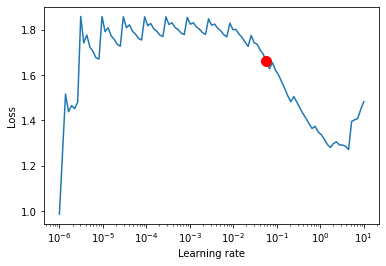

In [15]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [16]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=300,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [17]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:736: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  "`trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork    

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [18]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100,
    max_epochs=20,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(16, 128),
    hidden_continuous_size_range=(8, 64),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.0000001, 0.25),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=1.0),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-03-07 14:33:31,260] A new study created in memory with name: no-name-75805efa-5614-449d-bece-c4fec3faefd7
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:168: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  "Setting `Trainer(weights_summary=None)` is 

{'gradient_clip_val': 0.25712350405635515, 'hidden_size': 114, 'dropout': 0.11641663985302317, 'hidden_continuous_size': 17, 'attention_head_size': 4, 'learning_rate': 0.05455029596068588}


In [19]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [20]:
# calcualte mean absolute error on test set
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = best_tft.predict(test_dataloader)
(actuals - predictions).abs().mean()

tensor(1.7004)

In [21]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(test_dataloader, mode="raw", return_x=True)

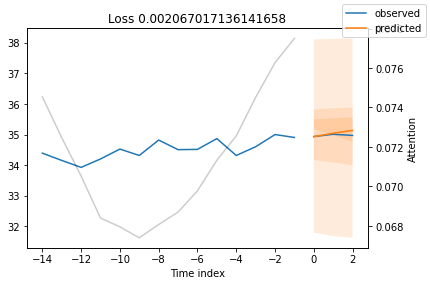

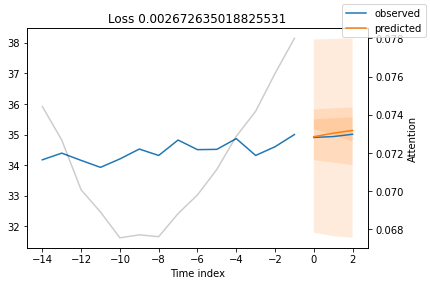

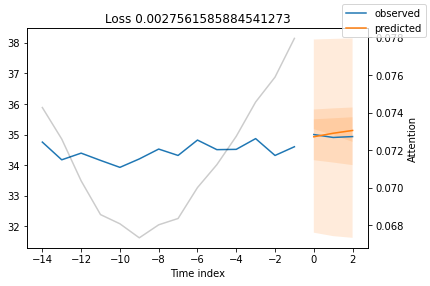

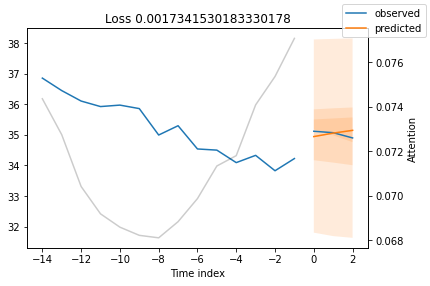

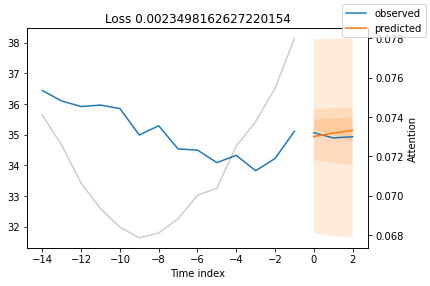

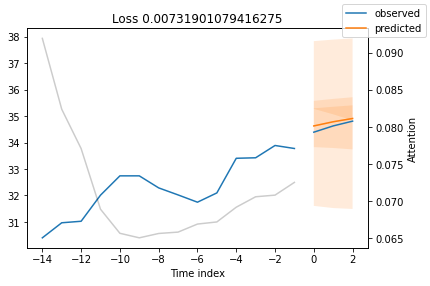

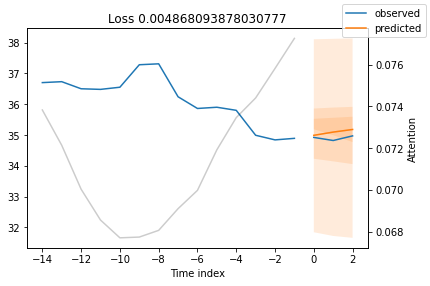

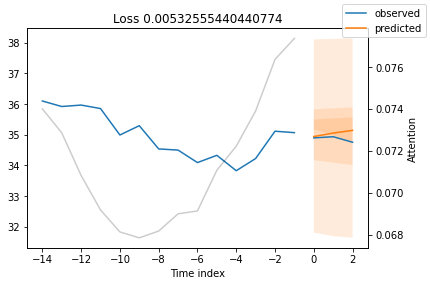

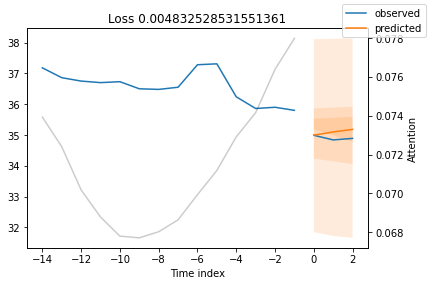

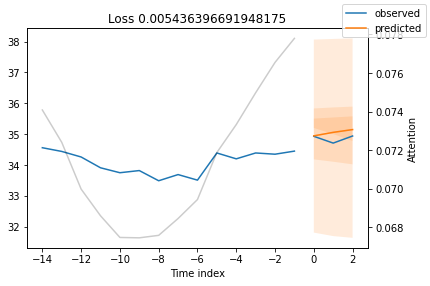

In [22]:
#display the best predictions
predictions = best_tft.predict(test_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=False)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );